In [26]:
from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from matplotlib.lines import Line2D
import numpy as np
import torchvision.utils as vutils
from functools import reduce, partial
import matplotlib.pyplot as plt

In [139]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def activity_square(vector):
    n = len(vector)
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)
    
def plot_act_distrs(distrs, n_labels=10, level='column'):  # level='cell'
    col_act_avgs = []
    n_plots = len(distrs.keys())
    fig, axs = plt.subplots(n_plots, 1, dpi=144, gridspec_kw={'hspace': 0.7})
    pi = 0
    for i in range(n_labels):
        for j in range(n_labels):
            key = '%d-%d' % (i, j)
            if key in distrs:
                activity_arr = distrs[key]
                dist = torch.stack(activity_arr)
                col_act = dist.max(dim=2).values
                ax = axs[pi]
                pi += 1
                bsz, m, n = dist.size()
                if level == 'column':
                    act = col_act
                elif level == 'cell':
                    col = col_act.view(bsz, m, 1)
                    act = torch.cat((dist, col), 2).view(bsz, m, n + 1)
                mean_act = act.mean(dim=0)
                ax.imshow(mean_act.t(), origin='bottom', extent=(0, m-1, 0, n+1))
                ax.plot([0, m-1], [n, n], linewidth=1)
                ax.axis('off')
                ax.set_title(key, fontsize=5)
    plt.show()
    return {}

def _plot_grad_flow(named_parameters):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend([Line2D([0], [0], color="c", lw=4),
                    Line2D([0], [0], color="b", lw=4),
                    Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [230]:
import rsm_samplers
import rsm
reload(rsm)
reload(rsm_samplers)

from torch.utils.data import DataLoader, BatchSampler

dataset = datasets.MNIST("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

bs=2
m=100
k=2
n=5
SEQ = [[0,1,2,3],[0,3,2,1]]
sl = 8
d_in = d_out = 28 ** 2
sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, randomize_sequences=True, random_mnist_images=False)
batch_sampler = rsm_samplers.PredictiveBatchSampler(sampler, batch_size=sl * bs)

collate_fn = partial(rsm_samplers.pred_sequence_collate, 
                     bsz=bs,
                     seq_length=sl,
                    return_inputs=True)
loader = DataLoader(dataset,
                    batch_sampler=batch_sampler,
                    collate_fn=collate_fn)
model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=m, n=n, k=k, visual_debug=False, debug=True)

criterion = MSELoss()

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

torch.Size([8, 2, 784])


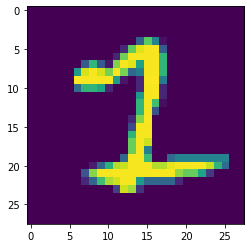

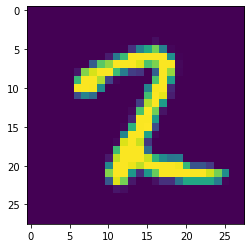

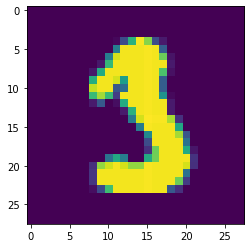

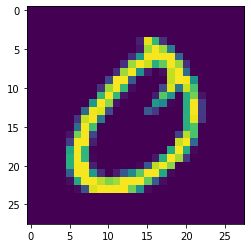

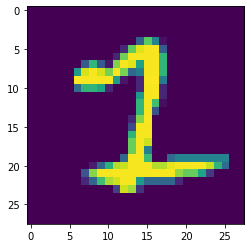

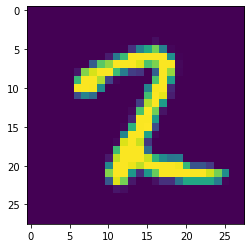

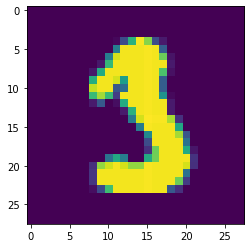

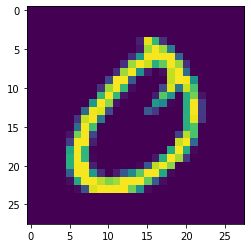

p tensor([[1, 3],
        [2, 2],
        [3, 1],
        [0, 0],
        [1, 3],
        [2, 2],
        [3, 1],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 1.0093,  1.0093,  1.0093,  1.0093,  1.0093, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.9765,  0.9765,
          0.9765,  0.9765,  0.9765,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.3282, -0.3282, -0.3282, -0.3282, -0.3282,  0.5485,  0.5485,  0.5485,
          0.5485,  0.5485,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  1.0978,  1.0978,  1.0978,

['x_a_next', tensor([[ 0.1689, -0.1060, -0.0647,  ...,  0.1421, -0.0211, -0.0256],
        [ 0.1002,  0.0111,  0.0090,  ...,  0.0352,  0.0140,  0.0471]],
       grad_fn=<AddmmBackward>), torch.Size([2, 784]), torch.float32]
['phi', tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
         0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4833,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4431, -0.0000,
  

['pi', tensor([[3.1275, 3.0906, 3.1357, 3.1140, 3.1188, 2.0906, 2.0662, 2.1038, 2.1114,
         2.0949, 2.0305, 2.0129, 1.9873, 1.9505, 1.9964, 2.8219, 2.8909, 2.8386,
         2.8999, 2.8403, 2.3765, 2.3754, 2.3715, 2.4332, 2.3558, 2.4307, 2.3945,
         2.4009, 2.4194, 2.3949, 2.5083, 2.5312, 2.5016, 2.4835, 2.5090, 2.3265,
         2.3167, 2.2791, 2.3401, 2.3601, 4.4284, 4.3707, 4.4365, 4.4131, 3.9024,
         3.5688, 3.5105, 3.5195, 3.5342, 3.5197, 2.5784, 2.6681, 2.6572, 2.5884,
         2.6123, 3.0737, 3.0604, 3.1084, 3.1003, 3.0448, 2.6564, 2.6598, 2.5866,
         2.5899, 2.5714, 1.9669, 1.9765, 1.9508, 1.9520, 1.9454, 3.4823, 3.4707,
         3.3961, 3.4464, 3.4439, 3.7715, 3.7619, 3.7657, 1.9786, 3.4117, 2.0506,
         2.0908, 2.0591, 2.0389, 2.0868, 2.4171, 2.4297, 2.4220, 2.4304, 2.4730,
         1.4838, 1.4673, 1.4873, 1.4691, 1.5094, 2.4421, 2.4294, 2.4813, 2.4453,
         2.4795, 2.5014, 2.5161, 2.5113, 2.5356, 2.5110, 2.4526, 2.4844, 2.4419,
         2.5217, 2.46

['M_lambda', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.

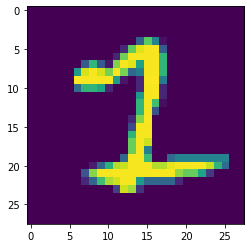

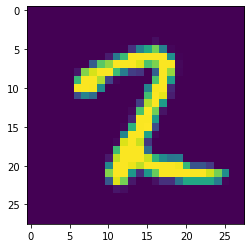

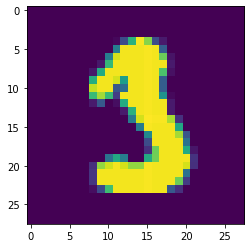

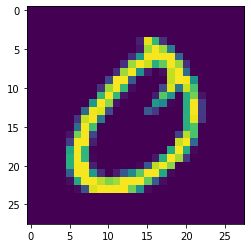

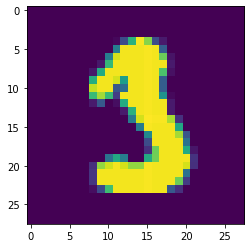

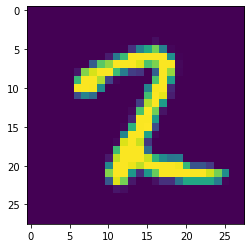

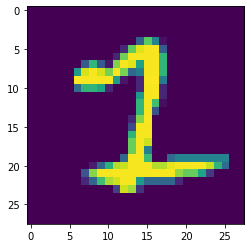

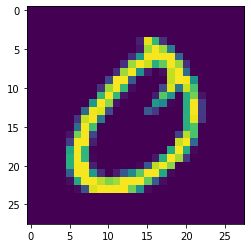

p tensor([[1, 1],
        [2, 2],
        [3, 3],
        [0, 0],
        [3, 1],
        [2, 2],
        [1, 3],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 1.0093,  1.0093,  1.0093,  1.0093,  1.0093, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.9765,  0.9765,
          0.9765,  0.9765,  0.9765,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.4690, -0.4690, -0.4690, -0.4690, -0.4690,  0.5485,  0.5485,  0.5485,
          0.5485,  0.5485,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  1.0978,  1.0978,  1.0978,

['z_a', tensor([[ 0.3941,  0.3941,  0.3941,  0.3941,  0.3941, -0.7065, -0.7065, -0.7065,
         -0.7065, -0.7065,  0.0809,  0.0809,  0.0809,  0.0809,  0.0809,  0.1603,
          0.1603,  0.1603,  0.1603,  0.1603, -0.5807, -0.5807, -0.5807, -0.5807,
         -0.5807, -0.2683, -0.2683, -0.2683, -0.2683, -0.2683, -0.4202, -0.4202,
         -0.4202, -0.4202, -0.4202,  0.0342,  0.0342,  0.0342,  0.0342,  0.0342,
          0.3639,  0.3639,  0.3639,  0.3639,  0.3639,  0.3575,  0.3575,  0.3575,
          0.3575,  0.3575, -0.4291, -0.4291, -0.4291, -0.4291, -0.4291,  0.7513,
          0.7513,  0.7513,  0.7513,  0.7513, -0.2297, -0.2297, -0.2297, -0.2297,
         -0.2297, -1.0994, -1.0994, -1.0994, -1.0994, -1.0994,  0.3949,  0.3949,
          0.3949,  0.3949,  0.3949,  0.4293,  0.4293,  0.4293,  0.4293,  0.4293,
         -0.0735, -0.0735, -0.0735, -0.0735, -0.0735, -0.0210, -0.0210, -0.0210,
         -0.0210, -0.0210, -1.0681, -1.0681, -1.0681, -1.0681, -1.0681, -0.0190,
         -0.0190, -0

['x_b', tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6445e-02, -0.0000e+00,
         1.1024e-03, -0.0000e+00, 6.9005e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         6.6004e-02, 7.4519e-03, 1.1529e-01, 0.0000e+00, 0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.000

['M_pi', tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0.

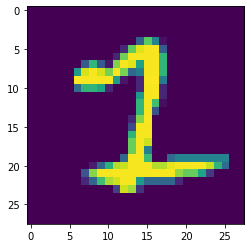

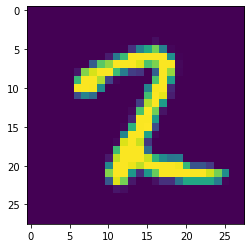

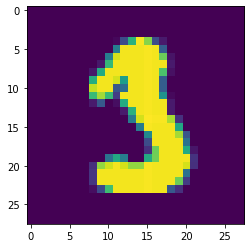

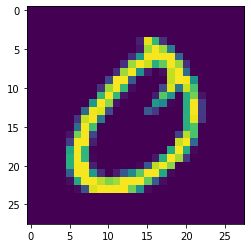

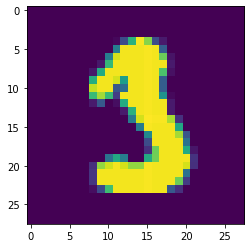

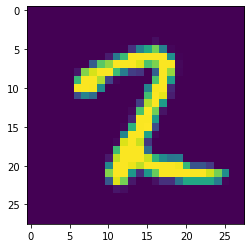

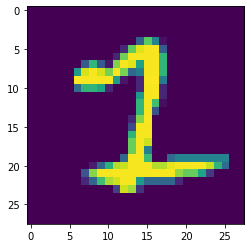

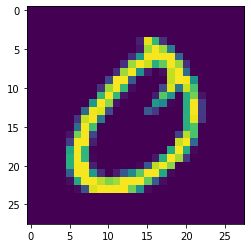

p tensor([[1, 3],
        [2, 2],
        [3, 1],
        [0, 0],
        [3, 1],
        [2, 2],
        [1, 3],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 1.0093,  1.0093,  1.0093,  1.0093,  1.0093, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.9765,  0.9765,
          0.9765,  0.9765,  0.9765,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.6100, -0.6100, -0.6100, -0.6100, -0.6100,  0.5485,  0.5485,  0.5485,
          0.5485,  0.5485,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  0.7449,  0.7449,  0.7449,

['pi', tensor([[2.7478, 2.7144, 1.6909, 2.7367, 2.7316, 1.6329, 1.6161, 1.6552, 1.6598,
         1.6374, 2.4663, 2.4475, 2.4251, 2.3806, 2.4356, 2.4771, 2.5432, 2.4983,
         2.5454, 2.4816, 1.7335, 1.7395, 1.7366, 1.7997, 1.7292, 2.0959, 2.0606,
         2.0658, 2.0993, 2.0503, 1.9456, 1.9580, 1.9200, 1.9213, 1.9331, 2.3938,
         2.3802, 2.3402, 2.3975, 2.4169, 2.3057, 2.2589, 2.3198, 2.3136, 1.8038,
         2.7433, 2.6848, 2.6961, 2.7072, 2.6866, 1.8735, 1.9639, 1.9464, 1.8919,
         1.9187, 3.0792, 3.0724, 3.1150, 3.1136, 3.0571, 1.9302, 1.9661, 1.8417,
         1.8920, 1.7700, 1.2470, 1.2434, 1.2192, 1.2152, 1.2179, 2.7770, 2.7721,
         2.6991, 2.7406, 2.7267, 2.4846, 2.4704, 2.4566, 2.5169, 2.5336, 2.2535,
         2.3047, 2.2929, 2.2709, 2.3059, 2.3068, 2.3220, 2.3076, 2.3198, 2.3605,
         1.2789, 1.2690, 1.2986, 1.2682, 1.2978, 2.3004, 2.2914, 2.3420, 2.3048,
         2.3475, 1.7298, 1.7505, 1.7419, 1.7584, 1.7344, 2.1245, 2.1505, 2.1173,
         2.1870, 2.14

['sigma', tensor([[ 9.7520e-01,  9.3563e-01,  9.9124e-01,  9.6455e-01,  9.5894e-01,
          4.1204e-01,  4.0551e-01,  4.4231e-01,  4.4185e-01,  4.2763e-01,
          4.1513e-01,  3.9833e-01,  3.8052e-01,  3.4983e-01,  3.8376e-01,
         -6.2501e-01, -5.6645e-01, -6.0678e-01, -5.5769e-01, -6.2418e-01,
         -3.8660e-01, -3.8435e-01, -3.7722e-01, -3.1814e-01, -4.0353e-01,
         -2.9959e-01, -3.3282e-01, -3.2193e-01, -2.9821e-01, -3.3490e-01,
          3.6998e-01,  3.9116e-01,  3.5098e-01,  3.5209e-01,  3.6283e-01,
          5.3333e-01,  5.1989e-01,  4.8514e-01,  5.4250e-01,  5.6063e-01,
          5.7179e-01,  5.0610e-01,  5.7088e-01,  5.5766e-01,  5.8074e-01,
          1.3140e+00,  1.2619e+00,  1.2679e+00,  1.2786e+00,  1.2647e+00,
          5.3735e-01,  6.0935e-01,  6.1612e-01,  5.5021e-01,  5.6284e-01,
          1.0989e+00,  1.0853e+00,  1.1284e+00,  1.1368e+00,  1.0719e+00,
          1.0668e+00,  1.0853e+00,  1.0078e+00,  9.9990e-01,  9.9637e-01,
         -3.3301e-01, -3.271

['y', tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
         0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         0.0000, -0.0000, -0.0000, -0.0000, 

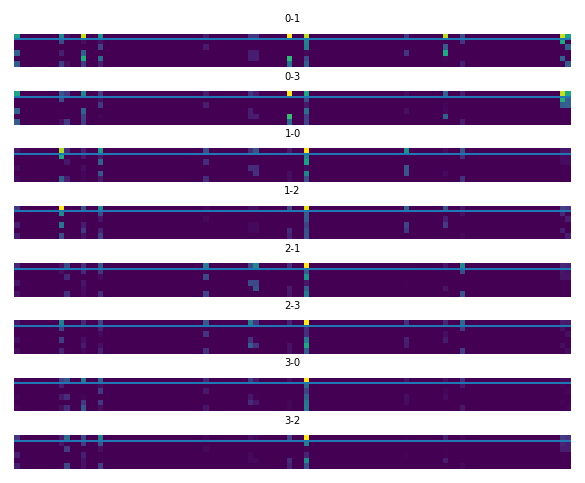

torch.Size([8, 2, 784])


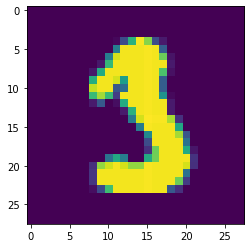

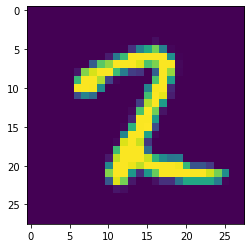

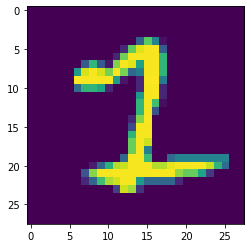

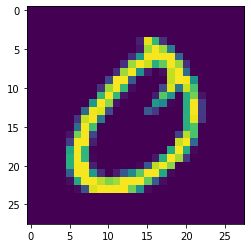

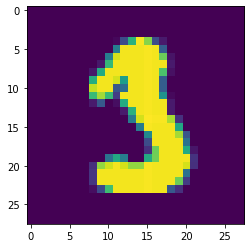

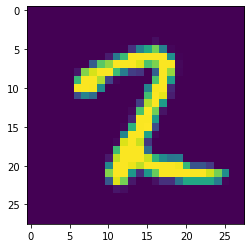

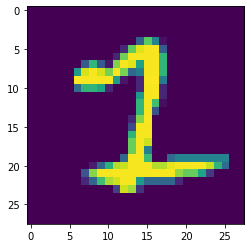

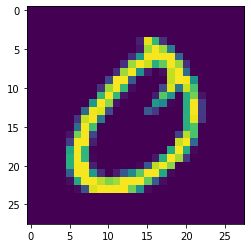

p tensor([[3, 1],
        [2, 2],
        [1, 3],
        [0, 0],
        [3, 3],
        [2, 2],
        [1, 1],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 0.6681,  0.6681,  0.6681,  0.6681,  0.6681, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.9765,  0.9765,
          0.9765,  0.9765,  0.9765,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.7191, -0.7191, -0.7191, -0.7191, -0.7191,  0.4129,  0.4129,  0.4129,
          0.4129,  0.4129,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  0.4721,  0.4721,  0.4721,

['M_pi', tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0.

['sigma', tensor([[ 0.8727,  0.8341,  0.8839,  0.8574,  0.8605,  0.4257,  0.4003,  0.4304,
          0.4516,  0.4255,  0.4287,  0.4016,  0.3750,  0.3391,  0.3853, -0.6355,
         -0.5702, -0.5982, -0.5592, -0.6246, -0.3852, -0.3893, -0.3782, -0.3227,
         -0.3903, -0.2945, -0.3276, -0.3203, -0.3009, -0.3356,  0.3704,  0.3849,
          0.3551,  0.3421,  0.3689,  0.5410,  0.5179,  0.4792,  0.5359,  0.5591,
          0.2990,  0.2285,  0.3043,  0.2754,  0.3068,  0.9054,  0.8607,  0.8639,
          0.8761,  0.8630,  0.5382,  0.6237,  0.6220,  0.5383,  0.5632,  1.0962,
          1.0844,  1.1287,  1.1269,  1.0549,  0.7492,  0.7534,  0.6776,  0.6737,
          0.6742, -0.3271, -0.3340, -0.3446, -0.3480, -0.3536, -0.0342, -0.0479,
         -0.1088, -0.0663, -0.0865,  0.6218,  0.6104,  0.6063,  0.6468,  0.6740,
         -0.6724, -0.6210, -0.6491, -0.6574, -0.6311,  0.0721,  0.0845,  0.0820,
          0.0904,  0.1306, -0.4746, -0.4899, -0.4707, -0.4883, -0.4438, -0.3026,
         -0.3174, 

['psi', tensor([[3.7451e-04, 0.0000e+00, 2.3555e-05, 0.0000e+00, 0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00,
         -0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, -0.0000e+00,
         9.4639e-02, 5.9537e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.1452e-07, 0.0000e+00,
         1.4381e-08, 0.0000e+00, 1.3763e-05, 2.1148e-04, 0.0000e+00, 0.0000e+00,
         8.3606e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         8.6100e-07, 9.7208e-08, 1.5039e-06, -0.0000e+00, 3.3937e-06, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.00

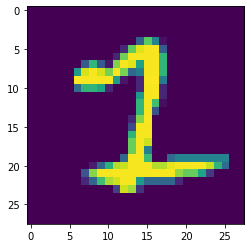

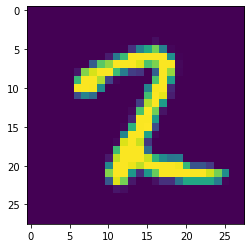

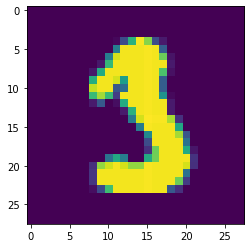

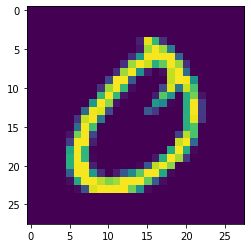

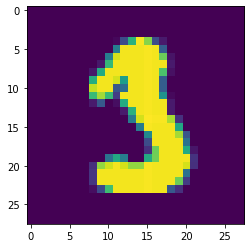

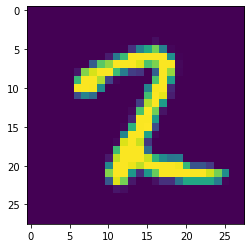

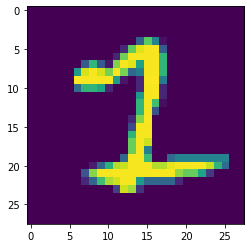

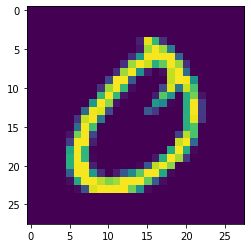

p tensor([[1, 1],
        [2, 2],
        [3, 3],
        [0, 0],
        [3, 3],
        [2, 2],
        [1, 1],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 0.3886,  0.3886,  0.3886,  0.3886,  0.3886, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.6657,  0.6657,
          0.6657,  0.6657,  0.6657,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.8084, -0.8084, -0.8084, -0.8084, -0.8084,  0.3017,  0.3017,  0.3017,
          0.3017,  0.3017,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  0.2486,  0.2486,  0.2486,

['pi', tensor([[2.6173, 2.5786, 2.6320, 2.6109, 2.6099, 1.6258, 1.6061, 1.6432, 1.6440,
         1.6284, 2.4573, 2.4419, 2.4128, 2.3802, 2.4338, 2.4731, 2.5372, 2.5006,
         2.5489, 2.4716, 1.7330, 1.7353, 1.7316, 1.8040, 1.7190, 2.0873, 2.0536,
         2.0575, 2.0839, 2.0483, 1.8198, 1.8853, 1.8536, 1.8628, 1.8605, 2.3876,
         2.3729, 2.3345, 2.3884, 2.4017, 1.7289, 1.6638, 1.7341, 1.7039, 1.7395,
         2.3576, 2.2973, 2.3243, 2.3241, 2.3048, 1.8712, 1.9446, 1.9455, 1.8783,
         1.9000, 3.0792, 3.0621, 3.1073, 3.1130, 3.0453, 1.6664, 1.6856, 1.6086,
         1.6083, 1.6034, 1.2286, 1.2311, 1.2157, 1.2177, 1.2052, 2.7695, 2.7666,
         2.6848, 2.7347, 2.7238, 2.0734, 2.0641, 2.0608, 2.1006, 2.1245, 2.2472,
         2.2970, 2.2828, 2.2608, 2.3000, 2.2959, 2.3196, 2.3028, 2.3190, 2.3546,
         1.2831, 1.2725, 1.2820, 1.2567, 1.2961, 2.3024, 2.2710, 2.3350, 2.2978,
         2.3417, 1.7206, 1.7397, 1.7321, 1.1419, 1.7289, 2.1151, 2.1480, 2.1025,
         2.1870, 2.11

['z_a', tensor([[ 0.7873,  0.7873,  0.7873,  0.7873,  0.7873,  0.4271,  0.4271,  0.4271,
          0.4271,  0.4271,  0.3868,  0.3868,  0.3868,  0.3868,  0.3868, -0.5999,
         -0.5999, -0.5999, -0.5999, -0.5999, -0.3581, -0.3581, -0.3581, -0.3581,
         -0.3581, -0.3094, -0.3094, -0.3094, -0.3094, -0.3094,  0.2707,  0.2707,
          0.2707,  0.2707,  0.2707,  0.5259,  0.5259,  0.5259,  0.5259,  0.5259,
          0.0467,  0.0467,  0.0467,  0.0467,  0.0467,  0.5438,  0.5438,  0.5438,
          0.5438,  0.5438,  0.5752,  0.5752,  0.5752,  0.5752,  0.5752,  1.1117,
          1.1117,  1.1117,  1.1117,  1.1117,  0.4471,  0.4471,  0.4471,  0.4471,
          0.4471, -0.3220, -0.3220, -0.3220, -0.3220, -0.3220, -0.0762, -0.0762,
         -0.0762, -0.0762, -0.0762,  0.3887,  0.3887,  0.3887,  0.3887,  0.3887,
         -0.6571, -0.6571, -0.6571, -0.6571, -0.6571,  0.0950,  0.0950,  0.0950,
          0.0950,  0.0950, -0.4785, -0.4785, -0.4785, -0.4785, -0.4785, -0.2710,
         -0.2710, -0

['M_pi', tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0.

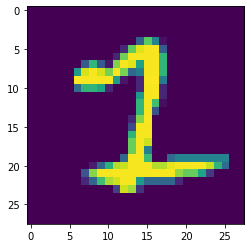

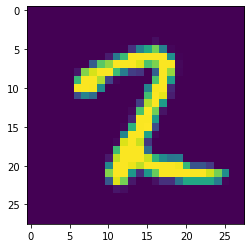

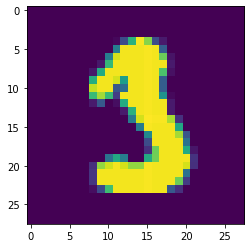

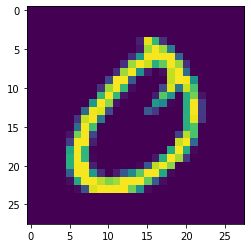

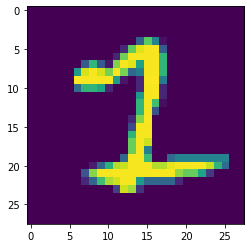

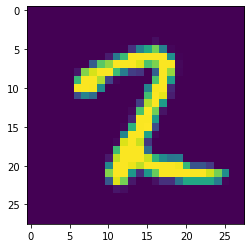

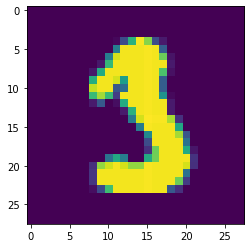

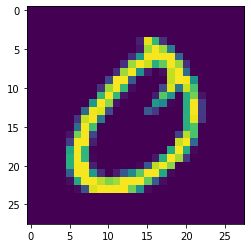

p tensor([[1, 3],
        [2, 2],
        [3, 1],
        [0, 0],
        [1, 3],
        [2, 2],
        [3, 1],
        [0, 0]])
['seqi', 0, '-', <class 'int'>]
['x_a_row', tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]), torch.Size([2, 784]), torch.float32]
['z_a', tensor([[ 0.1524,  0.1524,  0.1524,  0.1524,  0.1524, -0.2951, -0.2951, -0.2951,
         -0.2951, -0.2951, -0.1466, -0.1466, -0.1466, -0.1466, -0.1466,  0.0764,
          0.0764,  0.0764,  0.0764,  0.0764, -0.8002, -0.8002, -0.8002, -0.8002,
         -0.8002, -0.1072, -0.1072, -0.1072, -0.1072, -0.1072,  0.4030,  0.4030,
          0.4030,  0.4030,  0.4030,  0.6902,  0.6902,  0.6902,  0.6902,  0.6902,
         -0.8839, -0.8839, -0.8839, -0.8839, -0.8839,  0.2078,  0.2078,  0.2078,
          0.2078,  0.2078,  0.2903,  0.2903,  0.2903,  0.2903,  0.2903,  0.4577,
          0.4577,  0.4577,  0.4577,  0.4577,  0.0597,  0.0597,  0.0597,

['pi', tensor([[2.4310, 2.3981, 2.4524, 2.4229, 2.4263, 1.9790, 1.9586, 1.9918, 1.9944,
         1.9706, 2.1677, 2.1492, 2.1192, 2.0856, 2.1414, 2.3273, 2.3960, 2.3522,
         2.3920, 2.3375, 1.4434, 1.4538, 1.4614, 1.5216, 1.4340, 2.1860, 2.1530,
         2.1484, 2.1823, 2.1439, 2.6864, 2.7133, 2.6745, 2.6763, 2.6856, 2.9737,
         2.9647, 2.9279, 2.9781, 3.0038, 1.4224, 1.3657, 1.4286, 1.4087, 1.4374,
         2.5201, 2.4570, 2.4807, 2.4833, 2.4723, 2.5336, 2.6060, 2.6025, 2.5424,
         2.5556, 2.7153, 2.7085, 2.7595, 2.7578, 2.6963, 2.3729, 2.3912, 2.3022,
         2.3034, 2.3039, 1.7445, 1.7496, 1.7324, 1.7287, 1.7154, 3.0540, 3.0447,
         2.9728, 3.0154, 3.0087, 1.7245, 1.7080, 1.7116, 1.7525, 1.7807, 1.6751,
         1.7174, 1.6993, 1.6848, 1.7232, 1.9965, 2.0157, 2.0073, 2.0159, 2.0549,
         2.3532, 2.3485, 2.3565, 2.3354, 2.3786, 2.5012, 2.4831, 2.5497, 2.5002,
         2.5546, 2.8204, 2.5947, 2.8337, 2.8413, 2.8361, 2.1703, 2.2029, 2.1707,
         2.2288, 2.18

['z_a', tensor([[ 2.2639e-01,  2.2639e-01,  2.2639e-01,  2.2639e-01,  2.2639e-01,
         -7.0653e-01, -7.0653e-01, -7.0653e-01, -7.0653e-01, -7.0653e-01,
          8.0894e-02,  8.0894e-02,  8.0894e-02,  8.0894e-02,  8.0894e-02,
          1.6033e-01,  1.6033e-01,  1.6033e-01,  1.6033e-01,  1.6033e-01,
         -5.8067e-01, -5.8067e-01, -5.8067e-01, -5.8067e-01, -5.8067e-01,
         -2.6826e-01, -2.6826e-01, -2.6826e-01, -2.6826e-01, -2.6826e-01,
         -5.3253e-01, -5.3253e-01, -5.3253e-01, -5.3253e-01, -5.3253e-01,
          3.4184e-02,  3.4184e-02,  3.4184e-02,  3.4184e-02,  3.4184e-02,
         -8.6271e-01, -8.6271e-01, -8.6271e-01, -8.6271e-01, -8.6271e-01,
         -1.5777e-01, -1.5777e-01, -1.5777e-01, -1.5777e-01, -1.5777e-01,
         -4.2913e-01, -4.2913e-01, -4.2913e-01, -4.2913e-01, -4.2913e-01,
          7.5127e-01,  7.5127e-01,  7.5127e-01,  7.5127e-01,  7.5127e-01,
         -8.0449e-01, -8.0449e-01, -8.0449e-01, -8.0449e-01, -8.0449e-01,
         -1.0994e+00, -1.0994e

['psi', tensor([[4.5716e-08, 0.0000e+00, 2.8754e-09, 0.0000e+00, 0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1553e-05, 7.2677e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6186e-11, -0.0000e+00,
         1.7555e-12, -0.0000e+00, 1.6801e-09, 2.5815e-08, 0.0000e+00, 0.0000e+00,
         1.0206e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0510e-10, 1.1866e-11, 1.8359e-10, 0.0000e+00, 4.1427e-10, -0.0000e+00,
         -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 6.5034e-01, 0.000

['pi', tensor([[3.1322, 3.0965, 3.1506, 3.1194, 3.1183, 2.8375, 2.8101, 2.8501, 2.8502,
         2.8304, 2.8367, 2.8168, 2.7937, 2.7615, 2.8101, 1.7874, 1.8545, 1.8083,
         1.8520, 1.7941, 2.0285, 2.0318, 2.0387, 2.0966, 2.0169, 2.1229, 2.0818,
         2.0877, 2.1121, 2.0756, 2.6077, 2.6342, 2.5983, 2.6041, 2.6094, 2.9461,
         2.9306, 2.8980, 2.9491, 2.9742, 2.3040, 2.2380, 2.3041, 2.2842, 2.3056,
         2.7110, 2.6563, 2.6705, 2.6783, 2.6561, 2.9489, 3.0207, 3.0225, 2.9583,
         2.9733, 3.5111, 3.4995, 3.5450, 3.5468, 3.4862, 2.6630, 2.6867, 2.6004,
         2.5985, 2.6030, 2.0802, 2.0780, 2.0657, 2.0596, 2.0487, 1.9864, 2.3651,
         2.2861, 2.3345, 2.3244, 2.5752, 2.5523, 2.5541, 2.6004, 2.6227, 1.7409,
         1.7847, 1.7702, 1.7550, 1.7929, 2.4830, 2.5065, 2.4967, 2.5028, 2.5430,
         1.9403, 1.9269, 1.9501, 1.9208, 1.9661, 2.1170, 2.0948, 2.1627, 2.1244,
         2.1664, 3.0090, 3.0203, 3.0091, 3.0344, 3.0100, 2.5039, 2.5430, 2.5032,
         2.5677, 2.51

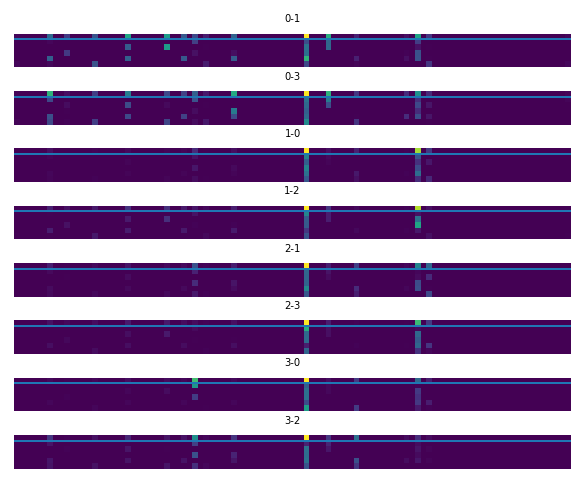

In [231]:
hidden = model.init_hidden(bs)

MAX_BATCHES = 2
CLASSES = 10
EPOCHS = 2

condtl_column_dists = {}  # 'digit-digit' -> list of distribution arrays

for epoch in range(EPOCHS):
    total_loss = 0.0
    for i, (data, targets, pred_targets, input_labels) in enumerate(loader):
        print(targets.size())
        for img in targets[:, 0]:
            plt.imshow(img.view(28, 28))
            plt.show()
        print('p', pred_targets)
        optimizer.zero_grad()
        output, hidden, x_bs = model(data, hidden)
        x_b, phi, psi = hidden
        for x_b_batch, label_batch, target_batch in zip(x_bs, input_labels, pred_targets):
            for _x_b, label, target in zip(x_b_batch, label_batch, target_batch):
                digit = label.item()
                next_digit = target.item()
                activity = _x_b.detach().view(m, -1)
                key = "%d-%d" % (digit, next_digit)
                if key not in condtl_column_dists:
                    condtl_column_dists[key] = []
                condtl_column_dists[key].append(activity)

        loss = criterion(output, targets)

        total_loss += loss.item()

        loss.backward()
        
        # _plot_grad_flow(model.named_parameters())
        optimizer.step()
        
        hidden = _repackage_hidden(hidden)

        if i >= MAX_BATCHES - 1:
            break

    print(epoch, 'loss', total_loss / (i+1))
    condtl_column_dists = plot_act_distrs(condtl_column_dists, n_labels=4, level='cell')

In [ ]:
a = torch.randn(2, 12).reshape(2, 4, 3)
print(a)
values, indices = torch.topk(a, 2)
print(indices)
arr = a.new_zeros(a.size())  # Zeros, conserve device
arr.scatter_(2, indices, 1)

In [ ]:
len(corpus.dictionary)

In [ ]:
[len(corpus.train), len(corpus.valid), len(corpus.test)]

In [ ]:
batch_size = 300
batches = len(corpus.train) / batch_size
0.25 * batches

In [ ]:
from torch.nn.functional import softmax

def topk_mask(a, k, dim=0, do_softmax=False):
    """
    Return a 1 for the top b elements in the last dim of a, 0 otherwise
    """
    if do_softmax:
        return softmax(a)
    else:
        values, indices = torch.topk(a, k)
    arr = a.new_zeros(a.size())  # Zeros, conserve device
    arr.scatter_(dim, indices, 1)
    return arr

a = torch.randn((3, 4))
print(a)
topk_mask(a, 1, dim=1, do_softmax=True)

In [ ]:
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt

class LocalLinear(nn.Module):
    """
    """
    def __init__(self, in_features, local_features, kernel_size, stride=1, bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

        fold_num = (in_features - self.kernel_size) // self.stride + 1
        self.lc = nn.ModuleList([deepcopy(nn.Linear(kernel_size, local_features, bias=bias))
                                 for _ in range(fold_num)])

    def forward(self, x):
        x = x.unfold(-1, size=self.kernel_size, step=self.stride)
        fold_num = x.shape[1]
        x = torch.cat([self.lc[i](x[:, i, :]) for i in range(fold_num)], 1)
        return x


class ActiveDendriteLayer(torch.nn.Module):
    """
    Local layer for active dendrites. Similar to a non-shared weight version of a 
    2D Conv layer.
    
    Note that dendrites are fully connected to input, local layer used only for connecting
    neurons and their dendrites
    """
    def __init__(self, input_dim, n_cells=50, n_dendrites=3):
        super(ActiveDendriteLayer, self).__init__()
        self.n_cells = n_cells
        self.n_dendrites = n_dendrites
        
        total_dendrites = n_dendrites * n_cells
        self.linear_dend = nn.Linear(input_dim, total_dendrites)
        self.linear_neuron = LocalLinear(total_dendrites, 1, n_dendrites, stride=n_dendrites)
        
    def __repr__(self):
        return "ActiveDendriteLayer neur=%d, dend per neuron=%d" % (self.n_cells, self.n_dendrites)
    
    def forward(self, x):
        x = F.relu(self.linear_dend(x))
        x = self.linear_neuron(x)
        return x
 
x = torch.randn(1, 5)
print(x)
adl = ActiveDendriteLayer(5, 4, 2)
print(adl(x))


In [ ]:
x = torch.randn(5, 3)
x[:, -2:] = 1
print(x)

In [33]:
class BitwiseWordEmbedding(object):

    def __init__(self, vocab_size=10000, dim=28):
        self.vocab_size = vocab_size
        self.embedding_dict = {}
        self.dim = dim

    def generate_embeddings(self):
        for i in range(self.vocab_size):
            self.embedding_dict[i] = self.embed(i)

    def embed(self, i):
        first = "{0:b}".format(i).zfill(self.dim // 2)
        return first + self.inverse(first)

    def inverse(self, binstr):
        return ''.join('1' if x == '0' else '0' for x in binstr)

bwe = BitwiseWordEmbedding()

bwe.embed(9381)

'1001001010010101101101011010'

In [8]:
from importlib import reload 
import viz_util
reload(viz_util)

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO
import io
import numpy as np
import matplotlib.pyplot as plt


ax, fig = viz_util.plot_confusion_matrix(np.array([1,2,3]), np.array([1,2,0]), ['0', '1', '2', '3'])

img = viz_util.fig2img(fig)

print(img.shape)
plt.imsave('test.png', img, format='png')


(288, 432, 3)


In [55]:
torch.range(0, 5).expand((3, 6)).t()

/Users/jgordon/miniconda3/envs/standard/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.


tensor([[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]])

In [27]:
from nupic.torch.functions import KWinners

kw = KWinners.apply

bsz = 2
m = 5
n = 3

k = 2

a = torch.rand(bsz, m, n)
print(a)
kw(a.view(bsz * m, n), 0, k, 0).view(bsz, m, n) > 0


tensor([[[0.2177, 0.5582, 0.1910],
         [0.0793, 0.9190, 0.8308],
         [0.4444, 0.2490, 0.6382],
         [0.4885, 0.0823, 0.4100],
         [0.4710, 0.3245, 0.6746]],

        [[0.0987, 0.9523, 0.1822],
         [0.0910, 0.5141, 0.2099],
         [0.9616, 0.5538, 0.5057],
         [0.1261, 0.0208, 0.4588],
         [0.0423, 0.1273, 0.3052]]])


tensor([[[1, 1, 0],
         [0, 1, 1],
         [1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]],

        [[0, 1, 1],
         [0, 1, 1],
         [1, 1, 0],
         [1, 0, 1],
         [0, 1, 1]]], dtype=torch.uint8)

In [97]:
sl = 2
bsz = 3
m = 5
n = 4
d_in = 10

x = torch.rand((sl, bsz, d_in))

x_a = x[0, :]  # first item

A = torch.nn.Linear(d_in, m)

u = A(x_a)
print(u, u.size())
z = u.repeat_interleave(n, 1)

print(z)

first_z_batch = z[1]
print(first_z_batch.view(m, n))

tensor([[ 0.2309,  0.2413,  0.0531,  0.1007, -0.1583],
        [ 0.1270,  0.2542, -0.0928,  0.0849, -0.4191],
        [ 0.2453,  0.2738,  0.1485,  0.0858, -0.2552]],
       grad_fn=<AddmmBackward>) torch.Size([3, 5])
tensor([[ 0.2309,  0.2309,  0.2309,  0.2309,  0.2413,  0.2413,  0.2413,  0.2413,
          0.0531,  0.0531,  0.0531,  0.0531,  0.1007,  0.1007,  0.1007,  0.1007,
         -0.1583, -0.1583, -0.1583, -0.1583],
        [ 0.1270,  0.1270,  0.1270,  0.1270,  0.2542,  0.2542,  0.2542,  0.2542,
         -0.0928, -0.0928, -0.0928, -0.0928,  0.0849,  0.0849,  0.0849,  0.0849,
         -0.4191, -0.4191, -0.4191, -0.4191],
        [ 0.2453,  0.2453,  0.2453,  0.2453,  0.2738,  0.2738,  0.2738,  0.2738,
          0.1485,  0.1485,  0.1485,  0.1485,  0.0858,  0.0858,  0.0858,  0.0858,
         -0.2552, -0.2552, -0.2552, -0.2552]], grad_fn=<IndexSelectBackward>)
tensor([[ 0.1270,  0.1270,  0.1270,  0.1270],
        [ 0.2542,  0.2542,  0.2542,  0.2542],
        [-0.0928, -0.0928, -0.0928,

In [155]:
import timeit

import rsm_k_winners
reload(rsm_k_winners)

def run_kwin(size=50, scatter=True):
    return rsm_k_winners.KWinners.apply(torch.rand(size, size), 0, 10, 0, scatter)


In [127]:
run_kwin()

tensor([[0.4548, 0.8208, 0.3500,  ..., 0.0000, 0.0000, 0.2274],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8647, 0.0963,  ..., 0.7562, 0.0000, 0.6054],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3596, 0.8424, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4383, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6986]])

In [156]:
from timeit import Timer

t = Timer(lambda: run_kwin(scatter=True))
print('scatter', t.timeit(number=10000))

t = Timer(lambda: run_kwin(scatter=False))
print('no_scatter', t.timeit(number=10000))

scatter 0.9094837090015062
no_scatter 10.072980703000212


In [154]:
import rsm_k_winners
reload(rsm_k_winners)

a = torch.rand(3, 3)

print(a)

res_scatter = rsm_k_winners.KWinners.apply(a.clone(), 0, 2, 0, True)
res_no_scatter = rsm_k_winners.KWinners.apply(a.clone(), 0, 2, 0, False)

print(res_scatter)
print(res_no_scatter)
bool(torch.all(torch.eq(res_scatter, res_no_scatter)).item())

tensor([[0.1703, 0.4110, 0.3670],
        [0.3609, 0.5750, 0.4785],
        [0.5245, 0.6524, 0.4454]])
tensor([[2, 1],
        [2, 1],
        [0, 1]])
tensor([[0.0000, 0.4110, 0.3670],
        [0.0000, 0.5750, 0.4785],
        [0.5245, 0.6524, 0.0000]])
tensor([[0.0000, 0.4110, 0.3670],
        [0.0000, 0.5750, 0.4785],
        [0.5245, 0.6524, 0.0000]])


True

In [108]:
c = torch.rand(2, 5, 3)
col = c.max(dim=2).values.view(2, 5, 1)

torch.cat((c, col), 2).view(2, 5, 4)

tensor([[[0.0276, 0.0345, 0.7292, 0.7292],
         [0.2489, 0.4198, 0.7282, 0.7282],
         [0.0019, 0.8581, 0.1624, 0.8581],
         [0.4252, 0.5053, 0.3189, 0.5053],
         [0.1830, 0.2257, 0.6854, 0.6854]],

        [[0.2986, 0.2481, 0.7430, 0.7430],
         [0.8728, 0.5860, 0.5563, 0.8728],
         [0.9766, 0.8781, 0.5623, 0.9766],
         [0.4510, 0.7570, 0.0908, 0.7570],
         [0.8824, 0.4939, 0.8672, 0.8824]]])

In [223]:
import rsm_samplers
import rsm
reload(rsm)
reload(rsm_samplers)

sl = 8
bs = 2
sampler = rsm_samplers.MNISTSequenceSampler(dataset, sequences=SEQ, randomize_sequences=True, random_mnist_images=False)
batch_sampler = rsm_samplers.PredictiveBatchSampler(sampler, batch_size=sl * bs)

collate_fn = partial(rsm_samplers.pred_sequence_collate, 
                     bsz=bs,
                     seq_length=sl,
                    return_inputs=True)

loader = DataLoader(dataset,
                    batch_sampler=batch_sampler,
                    collate_fn=collate_fn)


In [224]:
for i, (data, target, pred_target, input_labels) in enumerate(loader):
    print(target.size())
    if i >= 1:
        break

for i, (data, target, pred_target, input_labels) in enumerate(loader):
    print(input_labels)    
    if i >= 1:
        break


torch.Size([8, 2, 784])
torch.Size([8, 2, 784])
tensor([[0, 0],
        [3, 1],
        [2, 2],
        [1, 3],
        [0, 0],
        [3, 3],
        [2, 2],
        [1, 1]])
tensor([[0, 0],
        [1, 3],
        [2, 2],
        [3, 1],
        [0, 0],
        [3, 1],
        [2, 2],
        [1, 3]])


In [225]:
torch.rand(8, 20, 784).view(-1, 784)

tensor([[0.4746, 0.1275, 0.3276,  ..., 0.8581, 0.1192, 0.0310],
        [0.4444, 0.7764, 0.5361,  ..., 0.7598, 0.4415, 0.7198],
        [0.8783, 0.9082, 0.8647,  ..., 0.3749, 0.2225, 0.5578],
        ...,
        [0.1888, 0.8416, 0.6615,  ..., 0.8291, 0.5087, 0.6790],
        [0.4598, 0.9062, 0.5635,  ..., 0.4482, 0.2935, 0.6302],
        [0.6069, 0.7628, 0.4363,  ..., 0.7414, 0.4687, 0.9490]])